USAR XTREMEBOOST (KMEANS, DBSCAN, OUTROS) PARA AGRUPAR OS REGISTROS
COM AS TABELAS NO BIGQUERY, CONSUMIR AS COISAS DE LÁ
ALEM DO XTREMBOOST LOCAL, RODAR O ML_KMEANS DO SPARK E O ML_KMEANS DO BIGQUERY

no README
- explicar q sao 2 notebooks
- o primeiro notebook utilizou as bases fisicas, sem se conectar na internet
- o segundo notebook foi utilizado para realizar as analises e criar os graficos, machine learning para o app streamlit
- as bases de dados não serão disponibilizadas em conjunto com o notebook, mas há um link para download delas no app streamlit

# 1) Instalando dependências externas

In [1]:
!pip install pyspark
!pip install google-cloud-bigquery
!pip install pywaffle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=884fa9d18d9e58ba4831fe1421e5f93f923eb308e735541985ef7a3c7d5da7aa
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 38.9 MB/s eta 0:00:00


In [2]:
from google.colab import auth
from google.colab import data_table
from google.cloud import bigquery
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from pywaffle import Waffle

# 2) Google Big Query

In [3]:
# estabelece a conexão com GCP Big Query
project = 'silver-axon-412605'
schema = 'postech_fiap_data_science_danilo'
location = 'US'
client = bigquery.Client(project = project, location = location)
data_table.enable_dataframe_formatter()

auth.authenticate_user()

In [4]:
# consulta todos os registros das tabelas de processados e auxiliares no Big Query e cria seus respectivos dataframes do pandas
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_processado
''')
df_pnad = query_job.result().to_dataframe()

In [5]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_capital
''')
df_capital = query_job.result().to_dataframe()
df_capital.id = df_capital.id.astype(int)

In [6]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_escolaridade
''')
df_escolaridade = query_job.result().to_dataframe()
df_escolaridade.id = df_escolaridade.id.astype(int)

In [7]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_medida_restricao
''')
df_medida_restricao = query_job.result().to_dataframe()
df_medida_restricao.id = df_medida_restricao.id.astype(int)

In [8]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_raca
''')
df_raca = query_job.result().to_dataframe()
df_raca.id = df_raca.id.astype(int)

In [9]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_regiao_metropolitana
''')
df_regiao_metropolitana = query_job.result().to_dataframe()
df_regiao_metropolitana.id = df_regiao_metropolitana.id.astype(int)

In [10]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_resultado
''')
df_resultado_exame = query_job.result().to_dataframe()
df_resultado_exame.id = df_resultado_exame.id.astype(int)

In [11]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_resposta
''')
df_resposta = query_job.result().to_dataframe()
df_resposta.id = df_resposta.id.astype(int)

In [12]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_sexo
''')
df_sexo = query_job.result().to_dataframe()
df_sexo.id = df_sexo.id.astype(int)

In [13]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_situacao_domicilio
''')
df_situacao_domicilio = query_job.result().to_dataframe()
df_situacao_domicilio.id = df_situacao_domicilio.id.astype(int)

In [14]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_tipo_area
''')
df_tipo_area = query_job.result().to_dataframe()
df_tipo_area.id = df_tipo_area.id.astype(int)

In [15]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_uf
''')
df_uf = query_job.result().to_dataframe()
df_uf.id = df_uf.id.astype(int)

In [16]:
df_pnad.shape

(1149197, 31)

In [17]:
df_pnad.head()

,uf,capital,regiao_metropolitana,semana_mes_v1012,mes_v1013,situacao_domicilio_v1022,tipo_area_v1023,morador_idade_a002,morador_sexo_a003,morador_raca_a004,...,sintoma_perda_olfato_b00111,sintoma_dor_muscular_b00112,sintoma_diarreia_b00113,compareceu_estabelecimento_saude_b002,sedado_entubado_b006,tem_plano_saude_b007,resultado_exame_b009b,medida_restricao_contato_b011,trabalhou_remoto_c013,recebeu_auxilio_emergencial_d0051
0,11,11,<NA>,1,11,1,1,11,2,1,...,2,2,2,<NA>,<NA>,2,<NA>,2,<NA>,1
1,11,11,<NA>,4,11,1,1,5,2,4,...,2,2,2,<NA>,<NA>,1,<NA>,4,<NA>,2
2,11,11,<NA>,3,11,1,1,1,2,1,...,2,2,2,<NA>,<NA>,2,<NA>,2,<NA>,2
3,11,11,<NA>,1,11,1,1,9,1,1,...,2,2,2,<NA>,<NA>,1,<NA>,4,<NA>,2
4,11,11,<NA>,4,11,1,1,1,2,1,...,2,2,2,<NA>,<NA>,2,<NA>,4,<NA>,2


In [18]:
df_pnad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149197 entries, 0 to 1149196
Data columns (total 31 columns):
 #   Column                                 Non-Null Count    Dtype
---  ------                                 --------------    -----
 0   uf                                     1149197 non-null  Int64
 1   capital                                270626 non-null   Int64
 2   regiao_metropolitana                   363972 non-null   Int64
 3   semana_mes_v1012                       1149197 non-null  Int64
 4   mes_v1013                              1149197 non-null  Int64
 5   situacao_domicilio_v1022               1149197 non-null  Int64
 6   tipo_area_v1023                        1149197 non-null  Int64
 7   morador_idade_a002                     1149197 non-null  Int64
 8   morador_sexo_a003                      1149197 non-null  Int64
 9   morador_raca_a004                      1149197 non-null  Int64
 10  morador_escolaridade_a005              1149197 non-null  Int64
 11

In [19]:
# cria um schema do Spark para conversão do dataframe do pandas num dataframe do Spark
schema = StructType([StructField(x, IntegerType(), True) for x in df_pnad.columns])

In [20]:
# cria a sessão no Spark
spark = SparkSession.builder.master("local[*]").getOrCreate()
# converte o dataframe do pandas com o schema previamente criado num dataframe do Spark
df_pnad_spark = spark.createDataFrame(df_pnad, schema=schema, verifySchema=False)
# cria uma view da PNAD dentro do contexto do Spark
df_pnad_spark.createOrReplaceTempView('pnad')

In [21]:
# verificando a quantidade de registros no dataframe Spark
print(df_pnad_spark.count())

1149197


In [22]:
# verificando a quantidade de registros na view (deve bater com as outras contagens)
spark.sql('''
  SELECT COUNT(1) as total
  FROM pnad
''').show()

+-------+
|  total|
+-------+
|1149197|
+-------+



In [23]:
df_pnad_spark.printSchema()

root
 |-- uf: integer (nullable = true)
 |-- capital: integer (nullable = true)
 |-- regiao_metropolitana: integer (nullable = true)
 |-- semana_mes_v1012: integer (nullable = true)
 |-- mes_v1013: integer (nullable = true)
 |-- situacao_domicilio_v1022: integer (nullable = true)
 |-- tipo_area_v1023: integer (nullable = true)
 |-- morador_idade_a002: integer (nullable = true)
 |-- morador_sexo_a003: integer (nullable = true)
 |-- morador_raca_a004: integer (nullable = true)
 |-- morador_escolaridade_a005: integer (nullable = true)
 |-- sintoma_febre_b0011: integer (nullable = true)
 |-- sintoma_tosse_b0012: integer (nullable = true)
 |-- sintoma_dor_garganta_b0013: integer (nullable = true)
 |-- sintoma_dificuldade_respiracao_b0014: integer (nullable = true)
 |-- sintoma_dor_cabeca_b0015: integer (nullable = true)
 |-- sintoma_dor_peito_b0016: integer (nullable = true)
 |-- sintoma_nausea_b0017: integer (nullable = true)
 |-- sintoma_nariz_entupido_b0018: integer (nullable = true)
 |-

In [24]:
df_pnad_spark.show(5)

+---+-------+--------------------+----------------+---------+------------------------+---------------+------------------+-----------------+-----------------+-------------------------+-------------------+-------------------+--------------------------+------------------------------------+------------------------+-----------------------+--------------------+----------------------------+--------------------+------------------------+---------------------------+---------------------------+-----------------------+-------------------------------------+--------------------+--------------------+---------------------+-----------------------------+---------------------+---------------------------------+
| uf|capital|regiao_metropolitana|semana_mes_v1012|mes_v1013|situacao_domicilio_v1022|tipo_area_v1023|morador_idade_a002|morador_sexo_a003|morador_raca_a004|morador_escolaridade_a005|sintoma_febre_b0011|sintoma_tosse_b0012|sintoma_dor_garganta_b0013|sintoma_dificuldade_respiracao_b0014|sintoma_dor_

# 3) Segmentando o público

## 3.1) Sexo

In [25]:
df_sexo

,id,nome
0,2,Mulher
1,1,Homem


In [26]:
# testando manualmente
total_homens = len(df_pnad[df_pnad['morador_sexo_a003'] == 1])
total_mulheres = len(df_pnad[df_pnad['morador_sexo_a003'] == 2])

print(f'Homens: {total_homens}')
print(f'Mulheres: {total_mulheres}')

Homens: 550656
Mulheres: 598541


In [157]:
# preparando o dataframe segmentado
sexo_segmentado = df_pnad['morador_sexo_a003'].value_counts() # faz a contagem por categoria (sexo)
df_pnad_sexo = pd.DataFrame({'id': sexo_segmentado.index, 'total': sexo_segmentado.values})
df_pnad_sexo = pd.merge(df_pnad_sexo, df_sexo, on='id', how='inner')
df_pnad_sexo.to_csv('segmentacao-sexo.csv', index=False)
df_pnad_sexo.head()

,id,total,nome
0,2,598541,Mulher
1,1,550656,Homem


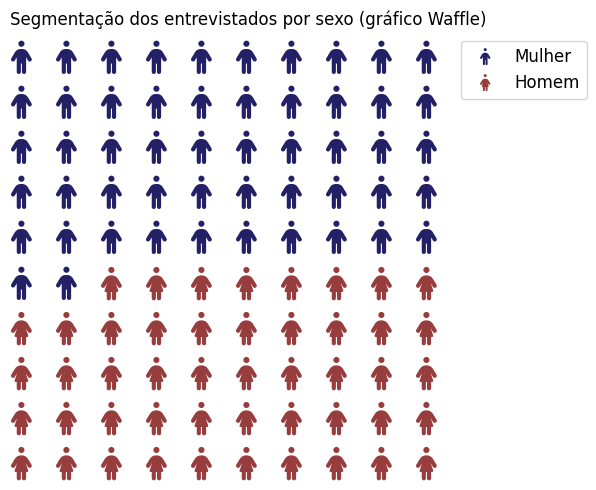

In [167]:
sexo_cores = ['#983D3D', '#232066']
waffle_icons = ['person', 'person-dress']

fig = go.Figure()
fig.add_trace(go.Pie(labels=df_pnad_sexo.nome, values=df_pnad_sexo.total, hole=.65, marker=dict(colors=sexo_cores)))
fig.update_layout(title='Segmentação dos entrevistados por sexo')
fig.show()

fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    columns=10,
    vertical=True,
    starting_location='NW',
    icons=waffle_icons,
    icon_legend =True,
    labels=df_pnad_sexo.nome.values.tolist(),
    values=df_pnad_sexo.total.values.tolist(),
    colors=sexo_cores[::-1],
    title={'label': 'Segmentação dos entrevistados por sexo (gráfico Waffle)', 'loc': 'left'},
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1), 'fontsize': 12},
    plot_anchor='C'
)
plt.show()

## 3.2) Estado

In [92]:
# preparando o dataframe segmentado
uf_segmentado = df_pnad['uf'].value_counts() # faz a contagem por categoria (uf)
df_pnad_uf = pd.DataFrame({'id': uf_segmentado.index, 'total': uf_segmentado.values})
df_pnad_uf = pd.merge(df_pnad_uf, df_uf, on='id', how='inner')
df_pnad_uf.to_csv('segmentacao-uf.csv', index=False)
df_pnad_uf.head()

,id,total,nome
0,31,103096,Minas Gerais
1,35,98021,São Paulo
2,33,87405,Rio de Janeiro
3,42,70990,Santa Catarina
4,43,66446,Rio Grande do Sul


In [93]:
fig = go.Figure()
fig.add_trace(go.Bar(x=df_pnad_uf.nome.tolist(), y=df_pnad_uf.total.tolist()))
fig.update_layout(title='Segmentação dos entrevistados por UF')
fig.show()

## 3.3) Região metropolitana

In [98]:
# preparando o dataframe segmentado
regiao_metropolitana_segmentado = df_pnad['regiao_metropolitana'].value_counts() # faz a contagem por categoria (região metropolitana)
df_pnad_regiao_metropolitana = pd.DataFrame({'id': regiao_metropolitana_segmentado.index, 'total': regiao_metropolitana_segmentado.values})
df_pnad_regiao_metropolitana = pd.merge(df_pnad_regiao_metropolitana, df_regiao_metropolitana, on='id', how='inner')
df_pnad_regiao_metropolitana.to_csv('segmentacao-regiao-metropolitana.csv', index=False)
df_pnad_regiao_metropolitana.head()

,id,total,nome
0,33,58590,Região Metropolitana de Rio de Janeiro (RJ)
1,35,38160,Região Metropolitana de São Paulo (SP)
2,31,27963,Região Metropolitana de Belo Horizonte (MG)
3,32,22172,Região Metropolitana de Grande Vitória (ES)
4,43,21924,Região Metropolitana de Porto Alegre (RS)


In [101]:
fig = go.Figure()
fig.add_trace(go.Bar(x=df_pnad_regiao_metropolitana.nome.tolist(), y=df_pnad_regiao_metropolitana.total.tolist()))
fig.update_layout(title='Segmentação dos entrevistados por região metropolitana')
fig.show()

## 3.4) Escolaridade

In [168]:
# preparando o dataframe segmentado
escolaridade_segmentado = df_pnad['morador_escolaridade_a005'].value_counts() # faz a contagem por categoria (escolaridade)
df_pnad_escolaridade = pd.DataFrame({'id': escolaridade_segmentado.index, 'total': escolaridade_segmentado.values})
df_pnad_escolaridade = pd.merge(df_pnad_escolaridade, df_escolaridade, on='id', how='inner')
df_pnad_escolaridade.to_csv('segmentacao-escolaridade.csv', index=False)
df_pnad_escolaridade.head()

,id,total,nome
0,2,387986,Fundamental incompleto
1,5,256040,Médio completo
2,1,124035,Sem instrução
3,4,107635,Médio incompleto
4,7,107441,Superior completo


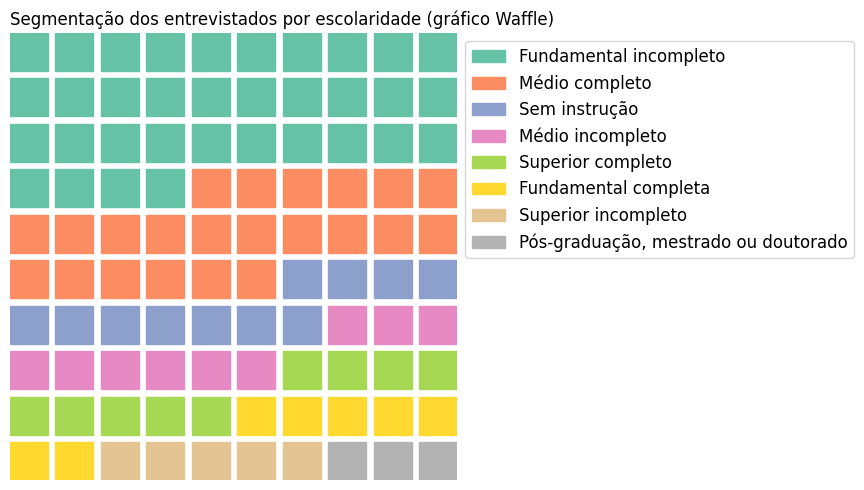

In [169]:
fig = go.Figure()
fig.add_trace(go.Pie(labels=df_pnad_escolaridade.nome.tolist(), values=df_pnad_escolaridade.total.tolist(), hole=.65))
fig.update_layout(title='Segmentação dos entrevistados por escolaridade')
fig.show()

fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    columns=10,
    vertical=True,
    starting_location='NW',
    labels=df_pnad_escolaridade.nome.tolist(),
    values=df_pnad_escolaridade.total.tolist(),
    title={'label': 'Segmentação dos entrevistados por escolaridade (gráfico Waffle)', 'loc': 'left'},
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1), 'fontsize': 12},
    plot_anchor='C'
)
plt.show()

## 3.5) Idade

In [184]:
# preparando o dataframe segmentado
idade_segmentado = df_pnad['morador_idade_a002'].value_counts(bins=[0, 18, 35, 50, 65, 80, 120], sort=False) # faz a contagem por categoria (faixa de idade)
df_pnad_idade = pd.DataFrame({'nome': idade_segmentado.index, 'total': idade_segmentado.values})
df_pnad_idade.to_csv('segmentacao-idade.csv', index=False)
df_pnad_idade.head()

,nome,total
0,"(-0.001, 18.0]",288774
1,"(18.0, 35.0]",271310
2,"(35.0, 50.0]",251661
3,"(50.0, 65.0]",208806
4,"(65.0, 80.0]",103593


In [192]:
df_pnad_idade.nome.astype(str)

0    (-0.001, 18.0]
1      (18.0, 35.0]
2      (35.0, 50.0]
3      (50.0, 65.0]
4      (65.0, 80.0]
5     (80.0, 120.0]
Name: nome, dtype: object

In [194]:
faixas_etarias = df_pnad_idade.nome.values.astype(str)
populacao = df_pnad_idade.total.values

# Criar o gráfico de barras horizontais
fig = go.Figure(go.Bar(
            x=populacao,
            y=faixas_etarias,
            orientation='h'))

# Atualizar o layout
fig.update_layout(title='Segmentação dos entrevistados por faixa etária',
                  xaxis_title='Número de indivíduos',
                  yaxis_title='Faixas etárias')

# Mostrar o gráfico
fig.show()

## 3.6) Tem plano de sáude?

In [201]:
# preparando o dataframe segmentado
plano_saude_segmentado = df_pnad['tem_plano_saude_b007'].value_counts() # faz a contagem por categoria (plano de saúde)
df_pnad_plano_saude = pd.DataFrame({'id': plano_saude_segmentado.index, 'total': plano_saude_segmentado.values})
df_pnad_plano_saude = pd.merge(df_pnad_plano_saude, df_resposta, on='id', how='inner')
df_pnad_plano_saude.to_csv('segmentacao-plano-saude.csv', index=False)
df_pnad_plano_saude.head()

,id,total,nome
0,2,886199,Não
1,1,260528,Sim
2,9,2470,Ignorado


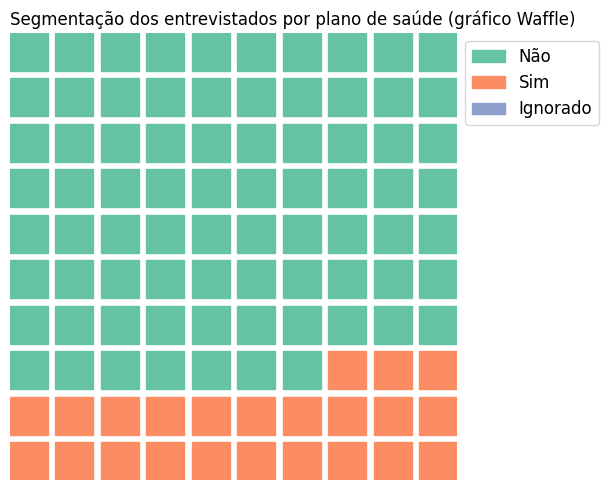

In [202]:
fig = go.Figure()
fig.add_trace(go.Pie(labels=df_pnad_plano_saude.nome, values=df_pnad_plano_saude.total, hole=.65))
fig.update_layout(title='Segmentação dos entrevistados por plano de saúde')
fig.show()

fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    columns=10,
    vertical=True,
    starting_location='NW',
    labels=df_pnad_plano_saude.nome.tolist(),
    values=df_pnad_plano_saude.total.tolist(),
    title={'label': 'Segmentação dos entrevistados por plano de saúde (gráfico Waffle)', 'loc': 'left'},
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1), 'fontsize': 12},
    plot_anchor='C'
)
plt.show()

## 3.7) Sintomas mais comuns

In [39]:
df_resposta

,id,nome
0,9,Ignorado
1,2,Não
2,3,Não sabe
3,1,Sim


In [40]:
colunas_sintomas = ['sintoma_febre_b0011',
       'sintoma_tosse_b0012', 'sintoma_dor_garganta_b0013',
       'sintoma_dificuldade_respiracao_b0014', 'sintoma_dor_cabeca_b0015',
       'sintoma_dor_peito_b0016', 'sintoma_nausea_b0017',
       'sintoma_nariz_entupido_b0018', 'sintoma_fadiga_b0019',
       'sintoma_dor_olhos_b00110', 'sintoma_perda_olfato_b00111',
       'sintoma_dor_muscular_b00112', 'sintoma_diarreia_b00113']
df_pnad_sintomas = df_pnad[colunas_sintomas]

In [41]:
df_pnad_sintomas.head()

,sintoma_febre_b0011,sintoma_tosse_b0012,sintoma_dor_garganta_b0013,sintoma_dificuldade_respiracao_b0014,sintoma_dor_cabeca_b0015,sintoma_dor_peito_b0016,sintoma_nausea_b0017,sintoma_nariz_entupido_b0018,sintoma_fadiga_b0019,sintoma_dor_olhos_b00110,sintoma_perda_olfato_b00111,sintoma_dor_muscular_b00112,sintoma_diarreia_b00113
0,2,2,2,2,2,2,2,2,2,2,2,2,2
1,2,2,2,2,2,2,2,2,2,2,2,2,2
2,2,2,2,2,2,2,2,2,2,2,2,2,2
3,2,2,2,2,2,2,2,2,2,2,2,2,2
4,2,2,2,2,2,2,2,2,2,2,2,2,2


In [42]:
# soma o total de casos por sintoma
total_por_sintoma = df_pnad_sintomas.apply(lambda col: (col == 1).sum())
total_por_sintoma

sintoma_febre_b0011                      9020
sintoma_tosse_b0012                     15373
sintoma_dor_garganta_b0013              12557
sintoma_dificuldade_respiracao_b0014     4799
sintoma_dor_cabeca_b0015                18960
sintoma_dor_peito_b0016                  3448
sintoma_nausea_b0017                     3958
sintoma_nariz_entupido_b0018            16140
sintoma_fadiga_b0019                     8208
sintoma_dor_olhos_b00110                 3671
sintoma_perda_olfato_b00111              4413
sintoma_dor_muscular_b00112             10883
sintoma_diarreia_b00113                  4301
dtype: int64

In [43]:
# Criar o gráfico de barras horizontais
fig = go.Figure(go.Bar(
            x=total_por_sintoma.values,
            y=total_por_sintoma.index,
            orientation='h'))

# Atualizar o layout
fig.update_layout(title='Distribuição por tipo de sintoma',
                  xaxis_title='Número de Indivíduos',
                  yaxis_title='Faixas Etárias')

# Mostrar o gráfico
fig.show()

In [44]:
df_pnad_sintomas.columns

Index(['sintoma_febre_b0011', 'sintoma_tosse_b0012',
       'sintoma_dor_garganta_b0013', 'sintoma_dificuldade_respiracao_b0014',
       'sintoma_dor_cabeca_b0015', 'sintoma_dor_peito_b0016',
       'sintoma_nausea_b0017', 'sintoma_nariz_entupido_b0018',
       'sintoma_fadiga_b0019', 'sintoma_dor_olhos_b00110',
       'sintoma_perda_olfato_b00111', 'sintoma_dor_muscular_b00112',
       'sintoma_diarreia_b00113'],
      dtype='object')

In [45]:
# Contar exclusivamente os registros que possuem o valor 1 em cada coluna
total_por_sintoma = df_pnad_sintomas.apply(lambda col: (col == 1).sum())

# Criar um DataFrame com os totais de cada sintoma
df_total_sintomas = pd.DataFrame({'sintoma': total_por_sintoma.index, 'total': total_por_sintoma.values})

# Criar um dicionário para mapear sintomas para categorias principais
categorias = {
    'sintoma_febre_b0011': 'Respiratório',
    'sintoma_tosse_b0012': 'Respiratório',
    'sintoma_dor_garganta_b0013': 'Respiratório',
    'sintoma_dificuldade_respiracao_b0014': 'Respiratório',
    'sintoma_dor_cabeca_b0015': 'Geral',
    'sintoma_dor_peito_b0016': 'Geral',
    'sintoma_nausea_b0017': 'Geral',
    'sintoma_nariz_entupido_b0018': 'Respiratório',
    'sintoma_fadiga_b0019': 'Geral',
    'sintoma_dor_olhos_b00110': 'Geral',
    'sintoma_perda_olfato_b00111': 'Respiratório',
    'sintoma_dor_muscular_b00112': 'Geral',
    'sintoma_diarreia_b00113': 'Gastrointestinal'
}

# Adicionar a coluna de categoria principal ao DataFrame de totais
df_total_sintomas['categoria'] = df_total_sintomas['sintoma'].map(categorias)
total_por_categoria = df_total_sintomas.groupby('categoria')['total'].sum()
df_total_sintomas['porcentagem'] = df_total_sintomas.apply(lambda x: (x['total'] / total_por_categoria[x['categoria']]) * 100, axis=1)

df_total_sintomas

,sintoma,total,categoria,porcentagem
0,sintoma_febre_b0011,9020,Respiratório,14.477866
1,sintoma_tosse_b0012,15373,Respiratório,24.674970
2,sintoma_dor_garganta_b0013,12557,Respiratório,20.155051
3,sintoma_dificuldade_respiracao_b0014,4799,Respiratório,7.702802
4,sintoma_dor_cabeca_b0015,18960,Geral,38.593063
5,sintoma_dor_peito_b0016,3448,Geral,7.018401
6,sintoma_nausea_b0017,3958,Geral,8.056505
7,sintoma_nariz_entupido_b0018,16140,Respiratório,25.906070
8,sintoma_fadiga_b0019,8208,Geral,16.707377
9,sintoma_dor_olhos_b00110,3671,Geral,7.472317


In [46]:
df_total_sintomas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sintoma      13 non-null     object 
 1   total        13 non-null     int64  
 2   categoria    13 non-null     object 
 3   porcentagem  13 non-null     float64
dtypes: float64(1), int64(1), object(2)
memory usage: 544.0+ bytes


In [47]:
import plotly.express as px

fig = px.treemap(
    df_total_sintomas,
    path=[px.Constant("Todos"), 'categoria', 'sintoma'],
    values='total',
    custom_data=['total', 'porcentagem'],
  )

# Atualizar layout para melhor visualização
fig.update_layout(
    title='Treemap de Sintomas da COVID-19',
    margin=dict(t=50, l=25, r=25, b=25),
)

fig.update_traces(
    hovertemplate='<b>%{label}</b><br>Total: %{customdata[0]}<br>Porcentagem: %{customdata[1]:.2f}%',
    texttemplate='<b>%{label}</b><br>%{customdata[1]:.2f}%',
    hoverlabel=dict(
        font=dict(color='white')
    ),
    textposition='middle center'
)

# Exibir o treemap
fig.show()

## 3.8) Sintoma + resultado positivo

In [48]:
colunas = colunas_sintomas.copy()
colunas.append('resultado_exame_b009b')

df_sintoma_resultado_positivo = df_pnad[colunas]

filtro_qualquer_sintoma_apresentado = (df_sintoma_resultado_positivo.iloc[:, :-1] == 1).any(axis=1)
filtro_covid_confirmado = (df_sintoma_resultado_positivo['resultado_exame_b009b'] == 1)
df_sintoma_resultado_positivo_filtrado = df_sintoma_resultado_positivo[filtro_qualquer_sintoma_apresentado & filtro_covid_confirmado]
df_sintoma_resultado_positivo_filtrado.head()

,sintoma_febre_b0011,sintoma_tosse_b0012,sintoma_dor_garganta_b0013,sintoma_dificuldade_respiracao_b0014,sintoma_dor_cabeca_b0015,sintoma_dor_peito_b0016,sintoma_nausea_b0017,sintoma_nariz_entupido_b0018,sintoma_fadiga_b0019,sintoma_dor_olhos_b00110,sintoma_perda_olfato_b00111,sintoma_dor_muscular_b00112,sintoma_diarreia_b00113,resultado_exame_b009b
1252,1,1,2,2,2,2,2,2,2,2,2,2,2,1
4720,1,2,1,2,1,2,2,2,2,2,2,1,2,1
7999,2,2,2,1,2,2,2,2,1,1,2,2,2,1
8006,2,2,2,2,1,2,2,2,2,2,1,1,2,1
9062,2,2,2,2,1,2,2,1,2,2,2,1,2,1


In [49]:
df_sintoma_resultado_positivo_filtrado

,sintoma_febre_b0011,sintoma_tosse_b0012,sintoma_dor_garganta_b0013,sintoma_dificuldade_respiracao_b0014,sintoma_dor_cabeca_b0015,sintoma_dor_peito_b0016,sintoma_nausea_b0017,sintoma_nariz_entupido_b0018,sintoma_fadiga_b0019,sintoma_dor_olhos_b00110,sintoma_perda_olfato_b00111,sintoma_dor_muscular_b00112,sintoma_diarreia_b00113,resultado_exame_b009b
1252,1,1,2,2,2,2,2,2,2,2,2,2,2,1
4720,1,2,1,2,1,2,2,2,2,2,2,1,2,1
7999,2,2,2,1,2,2,2,2,1,1,2,2,2,1
8006,2,2,2,2,1,2,2,2,2,2,1,1,2,1
9062,2,2,2,2,1,2,2,1,2,2,2,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144953,2,2,2,2,2,2,2,2,2,2,1,2,2,1
1145851,1,1,2,2,1,2,1,1,2,2,2,2,2,1
1145862,2,2,2,2,1,2,2,1,2,2,2,2,2,1
1147683,1,2,1,1,1,2,1,2,1,1,2,1,1,1


## 3.9) Escolaridade + resultado positivo

In [50]:
df_pnad.columns

Index(['uf', 'capital', 'regiao_metropolitana', 'semana_mes_v1012',
       'mes_v1013', 'situacao_domicilio_v1022', 'tipo_area_v1023',
       'morador_idade_a002', 'morador_sexo_a003', 'morador_raca_a004',
       'morador_escolaridade_a005', 'sintoma_febre_b0011',
       'sintoma_tosse_b0012', 'sintoma_dor_garganta_b0013',
       'sintoma_dificuldade_respiracao_b0014', 'sintoma_dor_cabeca_b0015',
       'sintoma_dor_peito_b0016', 'sintoma_nausea_b0017',
       'sintoma_nariz_entupido_b0018', 'sintoma_fadiga_b0019',
       'sintoma_dor_olhos_b00110', 'sintoma_perda_olfato_b00111',
       'sintoma_dor_muscular_b00112', 'sintoma_diarreia_b00113',
       'compareceu_estabelecimento_saude_b002', 'sedado_entubado_b006',
       'tem_plano_saude_b007', 'resultado_exame_b009b',
       'medida_restricao_contato_b011', 'trabalhou_remoto_c013',
       'recebeu_auxilio_emergencial_d0051'],
      dtype='object')

In [51]:
df_escolaridade

,id,nome
0,3,Fundamental completa
1,7,Superior completo
2,8,"Pós-graduação, mestrado ou doutorado"
3,5,Médio completo
4,1,Sem instrução
5,2,Fundamental incompleto
6,4,Médio incompleto
7,6,Superior incompleto


In [52]:
colunas = ['morador_escolaridade_a005', 'resultado_exame_b009b']

df_escolaridade_covid = df_pnad[df_pnad['resultado_exame_b009b'] == 1]
df_escolaridade_covid = df_escolaridade_covid[colunas].groupby('morador_escolaridade_a005').agg(contagem=('resultado_exame_b009b', 'count'))
df_escolaridade_covid

,contagem
morador_escolaridade_a005,
1,502
2,2279
3,827
4,1021
5,4269
6,1452
7,3133
8,967


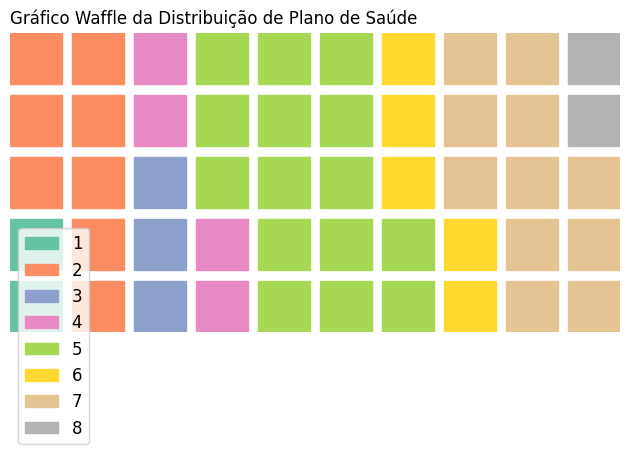

In [53]:
# donut
fig = go.Figure()
fig.add_trace(
      go.Pie(
          labels=df_escolaridade_covid.index,
          values=df_escolaridade_covid['contagem'],
          hole=.65
      )
    )
fig.update_layout(title='COVID19 confirmada X Plano de saúde')
fig.show()

# waffle
fig = plt.figure(
    FigureClass=Waffle,
    rows=5,
    columns=10,
    values=df_escolaridade_covid['contagem'],
    title={'label': 'Gráfico Waffle da Distribuição de Plano de Saúde', 'loc': 'left'},
    labels=df_escolaridade_covid.index.array,
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'fontsize': 12},
    plot_anchor='C'
)
plt.show()

## 3.10) Plano de saúde + resultado positivo

In [54]:
colunas = ['tem_plano_saude_b007', 'resultado_exame_b009b']

df_plano_saude_covid = df_pnad[(df_pnad['resultado_exame_b009b'] == 1)]
df_plano_saude_covid = df_plano_saude_covid[colunas].groupby('tem_plano_saude_b007').agg(contagem=('resultado_exame_b009b', 'count'))
df_plano_saude_covid

,contagem
tem_plano_saude_b007,
1,6714
2,7722
9,14


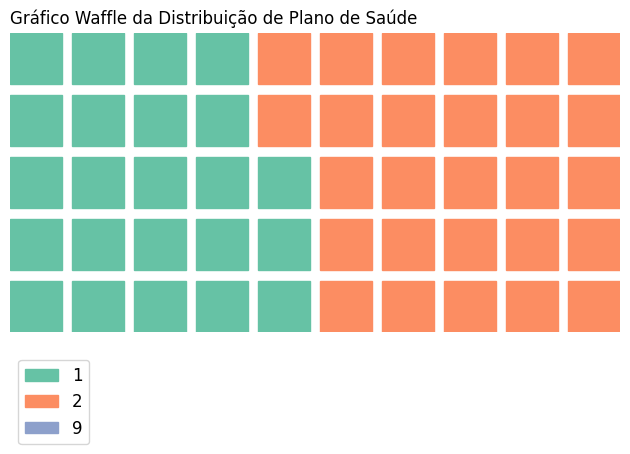

In [55]:
# donut
fig = go.Figure()
fig.add_trace(
      go.Pie(
          labels=df_plano_saude_covid.index,
          values=df_plano_saude_covid['contagem'],
          hole=.65
      )
    )
fig.update_layout(title='COVID19 confirmada X Plano de saúde')
fig.show()

# waffle
fig = plt.figure(
    FigureClass=Waffle,
    rows=5,
    columns=10,
    values=df_plano_saude_covid['contagem'],
    title={'label': 'Gráfico Waffle da Distribuição de Plano de Saúde', 'loc': 'left'},
    labels=df_plano_saude_covid.index.array,
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'fontsize': 12},
    plot_anchor='C'
)
plt.show()

## 3.11) Infectados mês à mês

In [57]:
# aqui decidimos executar a query dentro do próprio BigQuery
# portanto, simplesmente rodamos o job que representa a query
# vale notar que o id do job é reciclado depois de algumas horas, sendo necessário executar novamente
query_job = client.get_job('bquxjob_53b6ae0c_18de8d091cb')
df_casos_positivos_mes_a_mes = query_job.result().to_dataframe()
df_casos_positivos_mes_a_mes

,total,mes
0,3905,9
1,4756,10
2,5789,11


In [58]:
# Criar o gráfico de barras horizontais
fig = go.Figure(go.Bar(
            x=df_casos_positivos_mes_a_mes.mes,
            y=df_casos_positivos_mes_a_mes.total))

fig.add_trace(go.Scatter(x=df_casos_positivos_mes_a_mes.mes, y=df_casos_positivos_mes_a_mes.total, mode='lines', name='Linha de Tendência'))

# Atualizar o layout
fig.update_layout(title='Evolução dos casos positivos nos últimos 3 meses',
                  xaxis_title='Número de casos positivos',
                  yaxis_title='Mês')

# Mostrar o gráfico
fig.show()

## 3.12) Infectados por estado mês à mês

In [59]:
query_job = client.get_job('bquxjob_79ce4648_18de8d15087')
df_casos_positivos_mes_a_mes_por_uf = query_job.result().to_dataframe()
df_casos_positivos_mes_a_mes_por_uf

,total_casos_confirmados,mes,estado
0,88,Setembro,Acre
1,97,Outubro,Acre
2,108,Novembro,Acre
3,76,Setembro,Alagoas
4,76,Outubro,Alagoas
...,...,...,...
76,527,Outubro,São Paulo
77,567,Novembro,São Paulo
78,100,Setembro,Tocantins
79,106,Outubro,Tocantins


In [60]:
num_colors = len(df_casos_positivos_mes_a_mes_por_uf['estado'].unique())
colors = [f"hsl({h}, 50%, 50%)" for h in range(0, 320, int(320/num_colors))]

# Criando o gráfico de barras agrupado
fig = go.Figure()

for i, state in enumerate(df_casos_positivos_mes_a_mes_por_uf['estado'].unique()):
    state_data = df_casos_positivos_mes_a_mes_por_uf[df_casos_positivos_mes_a_mes_por_uf['estado'] == state]
    fig.add_trace(go.Bar(x=state_data['mes'], y=state_data['total_casos_confirmados'], name=state, marker_color=colors[i]))

# Configurando o layout
fig.update_layout(title='Total por Mês e Estado',
                  xaxis=dict(title='Mês'),
                  yaxis=dict(title='Total'),
                  barmode='group')

# Mostrando o gráfico
fig.show()

# 4) Machine Learning

In [61]:
matriz_correlacao = df_pnad.corr()

# Criar o Heatmap usando Plotly
fig = go.Figure(data=go.Heatmap(z=matriz_correlacao.values[::-1],
                                 x=matriz_correlacao.columns,
                                 y=matriz_correlacao.columns[::-1],
                                 colorbar=dict(title='Correlação'),
                                 colorscale='Viridis',
                                 xgap=1,
                                 ygap=1))

# Adicionar título ao gráfico
fig.update_layout(title='Matriz de Correlação', height=1200)
fig.update_layout(xaxis_side="top", xaxis=dict(tickangle=-45))

# Exibir o gráfico
fig.show()

## 4.1) Criando um modelo de previsão para identificar se um entrevistado está com covid ou não (utilizando métodos supervisionados e ensemble)

In [62]:
df_pnad.columns

Index(['uf', 'capital', 'regiao_metropolitana', 'semana_mes_v1012',
       'mes_v1013', 'situacao_domicilio_v1022', 'tipo_area_v1023',
       'morador_idade_a002', 'morador_sexo_a003', 'morador_raca_a004',
       'morador_escolaridade_a005', 'sintoma_febre_b0011',
       'sintoma_tosse_b0012', 'sintoma_dor_garganta_b0013',
       'sintoma_dificuldade_respiracao_b0014', 'sintoma_dor_cabeca_b0015',
       'sintoma_dor_peito_b0016', 'sintoma_nausea_b0017',
       'sintoma_nariz_entupido_b0018', 'sintoma_fadiga_b0019',
       'sintoma_dor_olhos_b00110', 'sintoma_perda_olfato_b00111',
       'sintoma_dor_muscular_b00112', 'sintoma_diarreia_b00113',
       'compareceu_estabelecimento_saude_b002', 'sedado_entubado_b006',
       'tem_plano_saude_b007', 'resultado_exame_b009b',
       'medida_restricao_contato_b011', 'trabalhou_remoto_c013',
       'recebeu_auxilio_emergencial_d0051'],
      dtype='object')

In [63]:
pnad_feature_columns = ['morador_raca_a004',
       'morador_escolaridade_a005', 'sintoma_febre_b0011',
       'sintoma_tosse_b0012', 'sintoma_dor_garganta_b0013',
       'sintoma_dificuldade_respiracao_b0014', 'sintoma_dor_cabeca_b0015',
       'sintoma_dor_peito_b0016', 'sintoma_nausea_b0017',
       'sintoma_nariz_entupido_b0018', 'sintoma_fadiga_b0019',
       'sintoma_dor_olhos_b00110', 'sintoma_perda_olfato_b00111',
       'sintoma_dor_muscular_b00112', 'sintoma_diarreia_b00113',
       'compareceu_estabelecimento_saude_b002', 'sedado_entubado_b006',
       'tem_plano_saude_b007', 'trabalhou_remoto_c013', 'recebeu_auxilio_emergencial_d0051']

pnad_target_column = ['resultado_exame_b009b']

In [64]:
from sklearn.model_selection import train_test_split

df_ml = df_pnad.copy()

df_ml.fillna(0, inplace=True)
df_ml = df_ml.sample(n=10000, random_state=777)
x = df_ml[pnad_feature_columns]
y = df_ml[pnad_target_column]

In [65]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=777)

In [66]:
print(f'shape x_train: {x_train.shape}')
print(f'shape x_test: {x_test.shape}')
print(f'shape y_train: {y_train.shape}')
print(f'shape y_test: {y_test.shape}')

shape x_train: (8000, 20)
shape x_test: (2000, 20)
shape y_train: (8000, 1)
shape y_test: (2000, 1)


In [67]:
x_train.head()

,morador_raca_a004,morador_escolaridade_a005,sintoma_febre_b0011,sintoma_tosse_b0012,sintoma_dor_garganta_b0013,sintoma_dificuldade_respiracao_b0014,sintoma_dor_cabeca_b0015,sintoma_dor_peito_b0016,sintoma_nausea_b0017,sintoma_nariz_entupido_b0018,sintoma_fadiga_b0019,sintoma_dor_olhos_b00110,sintoma_perda_olfato_b00111,sintoma_dor_muscular_b00112,sintoma_diarreia_b00113,compareceu_estabelecimento_saude_b002,sedado_entubado_b006,tem_plano_saude_b007,trabalhou_remoto_c013,recebeu_auxilio_emergencial_d0051
763907,1,5,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,2,0,1
838078,1,8,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,1,0,2
823289,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,2,0,2
626368,4,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,2,0,1
434020,4,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,2,0,1


In [68]:
y_train.rename(columns={'resultado_exame_b009b': 'y'}, inplace=True)

In [69]:
y_train.head()

,y
763907,0
838078,0
823289,0
626368,0
434020,0


In [70]:
y_train['y']

763907    0
838078    0
823289    0
626368    0
434020    0
         ..
901559    0
675636    0
647060    0
650445    0
517248    0
Name: y, Length: 8000, dtype: Int64

In [71]:
y_train['y'].values

<IntegerArray>
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 ...
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Length: 8000, dtype: Int64

In [72]:
y_train['y'].ravel()

<IntegerArray>
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 ...
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Length: 8000, dtype: Int64

In [73]:
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

In [74]:
def melhores_hiperparamentros_xgb(x_train, y_train):
    param_grid = {
      'learning_rate':[0.01, 0.05, 0.2],
      'n_estimators':[50, 100, 200],
      'max_depth': [1, 2, 5, 8]
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid = GridSearchCV(
      GradientBoostingClassifier(),
      param_grid = param_grid,
      scoring = 'f1',
      cv = cv,
      n_jobs= -1
    )

    grid.fit(x_train, y_train)  # Selecionando os melhores hiperparâmetros com base nos dados de treino
    xgb_params = grid.best_params_

    print("Melhores hiperparâmetros para XGB:", xgb_params)

    return xgb_params

In [75]:
# DESATIVADO PELO TEMPO DEMANDADO PARA EXECUÇÃO
# params = melhores_hiperparamentros_xgb(x_train, y_train)
# Melhores hiperparâmetros para XGB: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 50}

Rodando o XGB com os hiperparâmetros default

In [76]:
kfold = KFold(n_splits=30, shuffle=True)
xgb1 = GradientBoostingClassifier()
xgb1.fit(x_train, y_train['y'])
xgb1_result = cross_val_score(xgb1, x_train, y_train, cv = kfold)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning:


In [77]:
xgb1_result.mean()

0.9522509457163507

In [78]:
previsoes = xgb1.predict(x_test)
acuracia = accuracy_score(y_true = y_test, y_pred = previsoes) * 100
acuracia

95.39999999999999

Rodando com os hiperparâmetros sugeridos

In [79]:
kfold = KFold(n_splits=30, shuffle=True)
xgb2 = GradientBoostingClassifier(learning_rate=0.01, max_depth=1, n_estimators=50)
xgb2.fit(x_train, y_train['y'])
xgb2_result = cross_val_score(xgb2, x_train, y_train, cv = kfold)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning:


In [80]:
xgb2_result.mean()

0.9535003238433162

In [81]:
previsoes = xgb2.predict(x_test)
acuracia = accuracy_score(y_true = y_test, y_pred = previsoes) * 100
acuracia

95.35

## 4.2) Agrupando os entrevistados em grupos de acordo com suas caracteristicas, para identificar novos insights (com métodos não supervisionados)

In [82]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, silhouette_score

## 4.2.1) KMeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

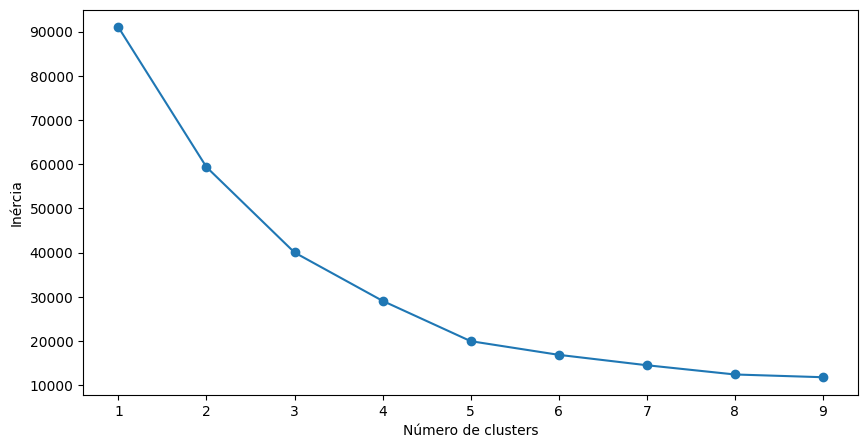

In [83]:
k_elbows = list(range(1, 10))
sse = []

# Roda o K-means para cada k fornecido
for i in k_elbows:
    kmeans = KMeans(n_clusters=i, random_state=777)
    kmeans.fit(x)
    sse.append(kmeans.inertia_) #calculo do erro do k-mens (mudar o centroide dos dados)

plt.rcParams['figure.figsize'] = (10, 5)
# Plota o gráfico com a soma dos erros quadraticos
plt.plot(k_elbows, sse, '-o')
plt.xlabel(r'Número de clusters')
plt.ylabel('Inércia')
plt.show()

Segundo o método Elbow, podemos definir entre 5 ou 6 centroides para o KMeans

In [84]:
# Definindo o modelo de clusterizacao. K-MEANS com 5 clusters
kmeans = KMeans(n_clusters=5,random_state=777)

#Implementando o K-Means nos dados:
kmeans.fit(x)

#Salvando os centroides de cada cluster
centroides = kmeans.cluster_centers_

#Salvando os labels dos clusters para cada exemplo
kmeans_labels = kmeans.predict(x)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [85]:
# utilizando PCA para tentar reduzir a dimensionalidade dos dados
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x)

### TODO: CORRIGIR ESSE PLOT, O PCA QUEBROU MAIS AINDA RS

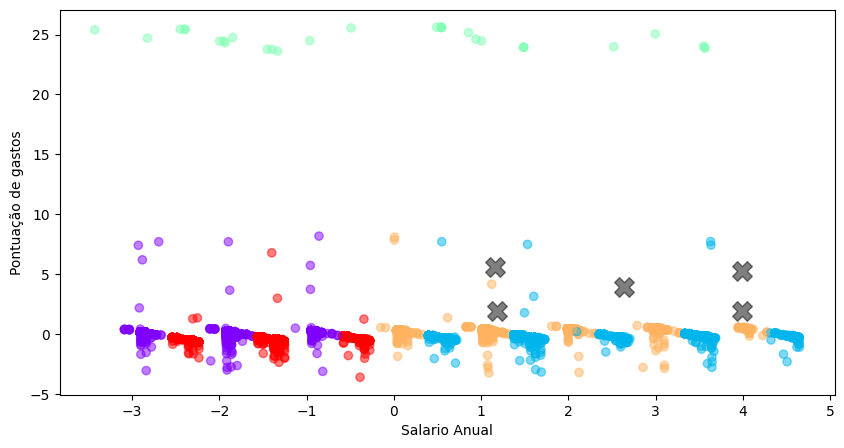

In [86]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, alpha=0.5, cmap='rainbow')
plt.xlabel('Salario Anual')
plt.ylabel('Pontuação de gastos')
# plotando os centroides
plt.scatter(centroides[:, 0], centroides[:, 1], c='black', marker='X', s=200, alpha=0.5)
plt.rcParams['figure.figsize'] = (10, 5)
plt.show()

In [87]:
# validar com silhouette_score e adjusted_rand_score
# metodo elbow para calcular quantidade de centroides

## 4.2.2) DBSCAN

### TODO: CORRIGIR ESSE PLOT, O PCA QUEBROU MAIS AINDA RS

In [88]:
#Criando o modelo:
dbscan = DBSCAN(eps=10, min_samples=8)
#Ajustando aos dados
dbscan.fit(x)

dbscan_labels = dbscan.labels_
dbscan_labels

array([0, 0, 0, ..., 0, 0, 0])

ValueError: 'c' argument has 10000 elements, which is inconsistent with 'x' and 'y' with size 200000.

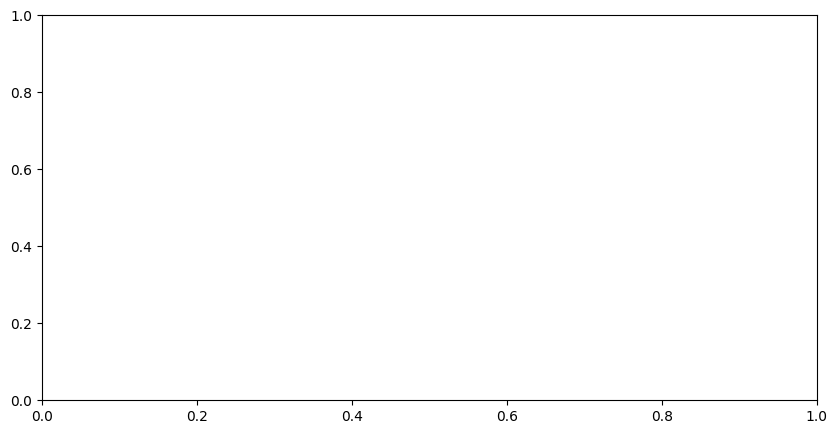

In [89]:
#Plotando o grafico:
plt.scatter(x, x, c=dbscan_labels, alpha=0.5, cmap='rainbow')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

## 4.2.3) Avaliando os resultados

### TODO: pq deu um valor tao baixo?

In [ ]:
# comparando os clusters entre cada método
adjusted_rand_score(kmeans_labels,dbscan_labels)

In [ ]:
# clusters mais ou menos separados
silhouette_score(x, kmeans_labels)

In [ ]:
# clusters relativamente bem separados
silhouette_score(x, dbscan_labels)